In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ffn
from Step2_EstimateCointModel import CointModel
%matplotlib inline

In [2]:
class Position(object):
    '''
    头寸类，包括名称、成本、数量、下单时间等
    '''
    def __init__(self,position_type='A',name='security',code='',price:float=None,quantity:int=None,time:pd.datetime=None,ratio=1):
        '''
        position_type:头寸类型，是A股还是H股
        '''
        self.position_type = position_type
        self.name = name
        self.code = code
        self.price = price
        self.quantity = quantity
        self.time = time
        self.ratio = ratio #交易配比，对于A股头寸来说默认值是1，对于港股配比来说是通过协整模型参数确定的

In [3]:
class PortFolio(object):
    '''
    资产组合类，包含更新净值、建仓、平仓、以及获得夏普比率、最大回撤、胜率等
    '''
    def __init__(self,money=1000000,time:pd.datetime=None,cost=True):
        '''
        构造函数
        money：初始资金        
        cost:是否计成本 True:计成本,False:不计成本
        '''
        self.money = money
        self.positions = {'long':Position(),'short':Position()} #目前的多头及空头头寸
        self.has_position = False #是否已有头寸，也就是是否存在未平仓头寸
        
        self.order_columns = ['操作','多头','空头','多头价格','空头价格','收益率','计成本收益率','持有天数','是否是止损']
        self.orders = pd.DataFrame(columns=self.order_columns) #每一笔交易都将记录在这里
        
        self.worth = pd.Series() #净值，用来计算每天的净值，便于画净值曲线
        self.cost = cost #计成本还是不计成本主要是影响净值的表现走势及平仓时收益，但是对于下单交易记录来说每一笔都会保留计成本和不计成本收益
        
        self.last_close_position_date = None ###用来记录最后一次平仓时间
    
    def update_worth_without_position(self,time:pd.datetime):
        '''
        没有头寸空仓期时更新净值，也就是没有波动
        '''
        self.worth = self.worth.append(pd.Series(self.money,index=[time]))
        print("没有头寸更新净值",self.worth[-1])

    def update_worth(self,long_position_current_price:float,short_position_current_price:float,time:pd.datetime):
        '''
        更新净值，每天更新一次，平仓时不更新，便于画图
        ratio:即交易配比
        '''
        long_position_return = long_position_current_price/self.positions['long'].price - 1
        short_position_return = 1 - short_position_current_price/self.positions['short'].price
        long_position_ratio = self.positions['long'].ratio
        short_positon_ratio = self.positions['short'].ratio
        r = (long_position_return*long_position_ratio + short_position_return*short_positon_ratio)/(long_position_ratio+short_positon_ratio)  
        self.worth = self.worth.append(pd.Series(self.money*r+self.money,index=[time]))
        print("有头寸更新净值r",r,self.worth[-1])
        
    def open_position(self,long_position:Position,short_position:Position):
        '''
        建仓
        '''
        assert not self.has_position,'已经持有头寸'
        self.positions['long'] = long_position
        self.positions['short'] = short_position
        print('买入 %s,价格 %.2f ; 卖出 %s,价格 %.2f ; 建仓时间 %s' % (long_position.code,long_position.price,short_position.code,
                                                           short_position.price,str(long_position.time.date())) )
        self.orders = self.orders.append(self.__get_order_data_frame(long_position.time,
                                                                     long_position.position_type,short_position.position_type,
                                                                     long_position.price,short_position.price,
                                                                     r='--',r_with_cost='--',hold_days='--',is_stop_loss='--'
                                                                    ))
        self.has_position = True
        
    def close_position(self,long_position:Position,short_position:Position,is_stop_loss=0):
        '''
        平仓
        *is_stop_loss:是否是止损平仓
        '''
        assert self.has_position,'没有头寸'
        long_position_return = long_position.price/self.positions['long'].price - 1
        short_position_return = 1 - short_position.price/self.positions['short'].price
        hold_days = (short_position.time - self.positions['short'].time).days ##计算持有天数
        #平仓操作，如果多头头寸为A股
        if long_position.position_type is 'A':
            long_position_return_with_cost = long_position_return - 0.001 - 0.00002*2 - 0.003*2 #减去印花税、过户费以及佣金
            short_position_return_with_cost = short_position_return - 0.001*2-0.00002*2-0.0025*2-0.00003*2 
        #多头头寸为H股
        else:
            long_position_return_with_cost = long_position_return - 0.001*2-0.00002*2-0.0025*2-0.00003*2
            short_position_return_with_cost = short_position_return - 0.001 - 0.00002*2 - 0.003*2 - hold_days*0.1035/360#还要减去融券费用
        
        long_position_ratio = self.positions['long'].ratio
        short_positon_ratio = self.positions['short'].ratio
            
        r = (long_position_return*long_position_ratio + short_position_return*short_positon_ratio)/(long_position_ratio+short_positon_ratio)   
        
        r_with_cost = (long_position_return_with_cost*long_position_ratio + short_position_return_with_cost*short_positon_ratio)/(long_position_ratio+short_positon_ratio)
        
        print('卖出 %s,价格 %.2f ; 买入 %s,价格 %.2f ; 平仓时间 %s ; 收益%s ； 计费用收益%s ' % (self.positions['long'].code,long_position.price,self.positions['short'].code,
                                                           short_position.price,str(long_position.time.date()),r,r_with_cost))
        if self.cost:
            self.money = self.money*r_with_cost+self.money
            self.worth = self.worth.append(pd.Series(self.money,index=[long_position.time])) #更新净值
        else:
            self.money = self.money*r+self.money
            self.worth = self.worth.append(pd.Series(self.money,index=[long_position.time]))
        ###无论是计成本还是不计成本，记录总会保留两个
        self.orders = self.orders.append(self.__get_order_data_frame(long_position.time,
                                                                     self.positions['long'].position_type,self.positions['short'].position_type,
                                                                     long_position.price,short_position.price,
                                                                     r=r,r_with_cost=r_with_cost,hold_days=hold_days,operation='平仓',is_stop_loss=is_stop_loss
                                                                    ))
        self.last_close_position_date = long_position.time #记录最后一次平仓时间
        self.has_position = False
        
    def __get_order_data_frame(self,time:pd.datetime,long:str,short:str,long_price:float,short_price:float,r,r_with_cost,hold_days:int,operation:str='建仓',is_stop_loss=0):
        '''
         获取交易记录的DataFrame对象，便于重复调用
        '''
        order = dict(zip(self.order_columns,[operation,long,short,long_price,short_price,r,r_with_cost,hold_days,is_stop_loss]))
        return pd.DataFrame(order,index=[time])
    
    def get_orders(self,verbose=0,save=True,file_name='orders'):
        '''
        获取交易记录
        verbose:0代表不打印,1代表打印
        save:是否保存文件
        '''
        if verbose:
            print(self.orders)
        if save:
            orders.to_excel(file_name+'.xlsx')
        return orders
    def get_sharp_ratio(self,rf:float=0.03):
        '''
        计算夏普比率
        *rf:为无风险利率，默认值为余额宝年化回报率3%左右
        return:不计成本夏普比率，计成本夏普比率
        '''
        def __get_annualized_return(r,hold_days):
            '''
            计算年化收益率
            '''
            return r/hold_days*365
        #计算每次收益的年化收益  ['操作','多头','空头','多头价格','空头价格','收益率','计成本收益率','持有天数','是否是止损']
        return_orders = self.orders[['收益率','计成本收益率','持有天数']].copy()
        #先剔除建仓记录 data[~data['交易状态'].isin(['停牌一天'])]
        return_orders = return_orders[~return_orders['收益率'].isin(['--'])]
        assert len(return_orders) is not 0,'no trade orders'
        for index,row in return_orders.iterrows():
            return_orders.loc[index,'收益率'] = __get_annualized_return(row['收益率'],row['持有天数'])
            return_orders.loc[index,'计成本收益率'] = __get_annualized_return(row['计成本收益率'],row['持有天数'])
        sharp_ratio = (np.mean(return_orders['收益率']) - rf)/np.std(return_orders['收益率'])
        sharp_ratio_with_cost = (np.mean(return_orders['计成本收益率']) - rf)/np.std(return_orders['计成本收益率'])
        print("计费用收益率标准差",np.std(return_orders['计成本收益率']))
        if self.cost:
            return sharp_ratio_with_cost
        else:
            return sharp_ratio
    
    def get_max_dropdown(self):
        '''
        计算最大回撤，返回全样本最大回撤
        '''
        assert len(self.orders['收益率'][~self.orders['收益率'].isin(['--'])]) is not 0,"no trade orders"
        return ffn.calc_max_drawdown(self.worth)
    
    def get_winning_prob(self):
        '''
        计算胜率
        '''
        def __get_wining_prob(return_list):
            assert len(return_list) is not 0,"no trade orders"
            return_list = np.array(return_list)
            return_list[return_list>0] = 1
            return_list[return_list<0] = 0
            return return_list.sum()/len(return_list)
        if self.cost:
            return __get_wining_prob(self.orders['计成本收益率'][~self.orders['计成本收益率'].isin(['--'])])
        else:
            return __get_wining_prob(self.orders['收益率'][~self.orders['收益率'].isin(['--'])])
    
    def get_r(self):
        '''
        计算总收益率
        '''
        temp_worth = self.worth[:self.last_close_position_date]
        r = (temp_worth[-1]-temp_worth[0])/temp_worth[0]
        return r
    
    def get_annualized_r(self):
        '''
        计算年化收益率
        '''
        r = self.get_r()
        days = (self.last_close_position_date-self.worth.index[0]).days
        return r/days*365

In [4]:
def back_test(file_name:str,money=1000000,gama:int=0,alpha1:float=1,alpha2:float=0,alpha3:float=2,cost=True):
    '''
    回测函数
    file_name:文件名字，带后缀
    money:初始资金
    gama:滑动平均交易信号最大后推日，当gama=0时，代表不进行滑动平均，当gama=20时代表使用近一个月的价差进行标准化
    alpha1:建仓阈值
    alpha2:平仓阈值
    alpha3:止损阈值
    cost:True为计成本回测，否则为不计成本回测
    
    return:下单记录，净值，价差，夏普比率，最大回撤，胜率，收益率，年化收益率
    '''
    def __get_quantity_by_money_price(money,price,base_number=100,e=1):
        '''
        根据资金及价格获取买几手,返回购买股票数量及实际购买金额
        e:代表汇率,港币兑人民币,如买港股直接提供汇率即可
        price:A股为人民币计价,H股为港元计价
        '''
        quantity = int((money/e)/price - (money/e)/ price % base_number)
        return quantity,quantity*price*e
    def __get_trade_ratio(b,beita,price_A):
        '''
        获取交易配比
        '''
        return np.e**b*price_A**(beita-1)
    
    data = pd.read_excel(file_name,index_col=0)
    H_code = data.columns[0]
    A_code = data.columns[1]
    data.drop(columns=['前收盘价','涨停价','跌停价'],inplace=True)
    data = data[~data['交易状态'].isin(['停牌一天'])]
    '''
    样本内
    '''
    sample_data = data.loc[:pd.datetime(2019,4,16)]
    ###估计协整模型得到系数及残差
    sample_H = np.log(sample_data.iloc[:,0])
    sample_A = np.log(sample_data.iloc[:,1])
    
    coint_model = CointModel(sample_H,sample_A)
    
    b,beita,sample_e = coint_model.fit()
    '''
    样本外
    '''
    out_sample_data = data.loc[pd.datetime(2019,4,17):]
    out_sample_H = np.log(out_sample_data.iloc[:,0])
    out_sample_A = np.log(out_sample_data.iloc[:,1])
    
    out_sample_e = out_sample_H - b - beita*out_sample_A
    '''
    合并样本内样本外残差
    '''
    total_sample_e = sample_e.append(out_sample_e)
    data['total_sample_e'] = total_sample_e
    ####先将残差标准化
    ###判断gama的值
    if gama is not 0:
        std_resid = data['total_sample_e'].copy()
        for i in range(gama,data.shape[0]):
            std_resid[i] = (data.iloc[i,5] - np.mean(data.iloc[i-gama:i+1,5]))/np.std(data.iloc[i-gama:i+1,5])
        data['total_sample_e'] = std_resid
    elif gama is 0:
        std_sample_e = (sample_e-sample_e.mean())/sample_e.std()
        std_out_sample_e = out_sample_e.copy()
        for i in range(out_sample_e.shape[0]):
            std_out_sample_e[i] = (out_sample_e[i] - np.mean(sample_e.append(out_sample_e[:i+1])))/np.std(sample_e.append(out_sample_e[:i+1]))
        data['total_sample_e'] = std_sample_e.append(std_out_sample_e)
    '''
    交易信号判断,alpha1:建仓,alpha2:平仓:alpha3:止损
    '''
    port_folio = PortFolio(money=money,time=data.index[gama],cost=cost)
    #读取汇率文件
    exchange = pd.read_excel('exchange.xlsx',index_col=0)
    for date,row in data.iloc[gama:,:].iterrows():
        '''
        循环每一天
        '''
        ##没有头寸可以进行建仓
        if not port_folio.has_position:
            #求出交易配比，注意要考虑到汇率
            ratio = __get_trade_ratio(b,beita,row[1])
            money_A = port_folio.money/(1+ratio)
            money_H = port_folio.money*ratio/(1+ratio)
            quantity_A,real_money_A = __get_quantity_by_money_price(money_A,row[1])
            quantity_H,real_money_H = __get_quantity_by_money_price(money_H,row[0],e=exchange.loc[date][0])
            #在根据实际交易金额重新修正配比
            real_ratio = real_money_H/real_money_A

            if row['total_sample_e']>=alpha1 and (row['是否开盘涨停'] is not 1):
                ## 建仓，价差为正 做多A股，做空港股
                #创建头寸
                long_position = Position(name=file_name[:-5],code=A_code,price=row[1],quantity=quantity_A,time=date)
                short_position = Position(position_type='H',name=file_name[:-5],code=H_code,price=row[0],quantity=quantity_H,time=date,ratio=real_ratio)
                #建仓
                port_folio.open_position(long_position,short_position)
                port_folio.update_worth_without_position(time=date)
                continue
            if row['total_sample_e']<=-alpha1 and (row['是否开盘跌停'] is not 1):
                ## 价差为负 做多H股，做空A股
                long_position = Position(position_type='H',name=file_name[:-5],code=H_code,price=row[0],quantity=quantity_H,time=date,ratio=real_ratio)
                short_position = Position(name=file_name[:-5],code=A_code,price=row[1],quantity=quantity_A,time=date)
                #建仓
                port_folio.open_position(long_position,short_position)
                port_folio.update_worth_without_position(time=date)
                continue
            #如果两个if都没有满足
            port_folio.update_worth_without_position(time=date)
        ####已有头寸，可以平仓或者止损处理
        else:
            ###首先判断持有头寸的类型，是多头头寸是A，还是空头头寸是A
            ###多头头寸是A股
            if port_folio.positions['long'].position_type is 'A':
                #由于多头头寸是A股，所以在建仓的时候价差为正，那么在价差继续扩大的时候进行止损
                if row['total_sample_e'] >= alpha3 and (row['是否开盘跌停'] is not 1):
                    long_position = Position(name=file_name[:-5],code=A_code,price=row[1],quantity=quantity_A,time=date)
                    short_position = Position(position_type='H',name=file_name[:-5],code=H_code,price=row[0],quantity=quantity_H,time=date) #注意在平仓的时候可以不给出交易配比
                    port_folio.close_position(long_position,short_position,is_stop_loss=1)
                    continue
                #多头头寸是A股，所以价差为负的时候进行平仓
                if row['total_sample_e'] <= -alpha2 and (row['是否开盘跌停'] is not 1):
                    long_position = Position(name=file_name[:-5],code=A_code,price=row[1],quantity=quantity_A,time=date)
                    short_position = Position(position_type='H',name=file_name[:-5],code=H_code,price=row[0],quantity=quantity_H,time=date) #注意在平仓的时候可以不给出交易配比
                    port_folio.close_position(long_position,short_position)
                    continue
                port_folio.update_worth(row[1],row[0],date)
            ###多头头寸是H股
            else:
                #由于多头头寸是H股,空头头寸是A股，所以初始价差为负，那么在价差继续缩小的时候进行止损
                if row['total_sample_e'] <= -alpha3 and (row['是否开盘涨停'] is not 1):
                    long_position = Position(position_type='H',name=file_name[:-5],code=H_code,price=row[0],quantity=quantity_H,time=date)
                    short_position = Position(name=file_name[:-5],code=A_code,price=row[1],quantity=quantity_A,time=date)
                    port_folio.close_position(long_position,short_position,is_stop_loss=1)
                    continue
                #多头头寸是H股，所以一开始的价差为负，那么当价差为正的时候进行平仓
                if row['total_sample_e'] >= alpha2 and (row['是否开盘涨停'] is not 1):
                    long_position = Position(position_type='H',name=file_name[:-5],code=H_code,price=row[0],quantity=quantity_H,time=date)
                    short_position = Position(name=file_name[:-5],code=A_code,price=row[1],quantity=quantity_A,time=date)
                    port_folio.close_position(long_position,short_position)
                    continue
                port_folio.update_worth(row[0],row[1],date)
    ##把价差和净值曲线合并到同一个DF并返回
    return port_folio.orders,port_folio.worth,data['total_sample_e'],port_folio.get_sharp_ratio(rf=0.03),port_folio.get_max_dropdown(),port_folio.get_winning_prob(),port_folio.get_r(),port_folio.get_annualized_r()

In [152]:
### 回测主函数调用
orders,worth,resid,sharp_ratio,max_dropdown,winning_prob,r,annualized_r = back_test('./data_without_formula/金风科技.xlsx',gama=0,alpha1=0.5,alpha2=0,alpha3=9999,cost=True)

买入 2208.HK,价格 12.37 ; 卖出 002202.SZ,价格 16.56 ; 建仓时间 2018-01-02
没有头寸更新净值 1000000
有头寸更新净值r 0.0035152321387520603 1003515.232138752
有头寸更新净值r -0.0030454651645680634 996954.534835432
有头寸更新净值r -0.012352851178971669 987647.1488210283
有头寸更新净值r -0.00024107582375962807 999758.9241762403
卖出 2208.HK,价格 12.57 ; 买入 002202.SZ,价格 16.24 ; 平仓时间 2018-01-09 ; 收益0.01806978309913273 ； 计费用收益0.009868980844149892 
买入 2208.HK,价格 12.18 ; 卖出 002202.SZ,价格 16.40 ; 建仓时间 2018-01-10
没有头寸更新净值 1009868.98084415
有头寸更新净值r 0.004310171225219603 1014221.6890666262
有头寸更新净值r 0.003265909210692673 1013167.1212502817
有头寸更新净值r 0.015869740118441417 1025895.3391238219
有头寸更新净值r 0.012009702018374995 1021997.2063816882
有头寸更新净值r 0.00632103145650593 1016252.3944390154
有头寸更新净值r 0.01537805694512617 1025398.8035386878
有头寸更新净值r 0.017641254189452667 1027684.3362332651
卖出 2208.HK,价格 12.50 ; 买入 002202.SZ,价格 16.11 ; 平仓时间 2018-01-22 ; 收益0.021617188092550893 ； 计费用收益0.012604371480430775 
买入 002202.SZ,价格 16.28 ; 卖出 2208.HK,价格 12.90 ; 建仓时间 2018-01-23
没

有头寸更新净值r 0.015683422921356244 1440062.941491246
有头寸更新净值r -0.0066164319018090076 1408445.6148648947
有头寸更新净值r 0.002849423347559981 1421866.5559243925
卖出 002202.SZ,价格 7.70 ; 买入 2208.HK,价格 5.35 ; 平仓时间 2018-10-31 ; 收益0.03518197803105554 ； 计费用收益0.028117077700733243 
没有头寸更新净值 1457691.7075722916
买入 002202.SZ,价格 8.16 ; 卖出 2208.HK,价格 6.03 ; 建仓时间 2018-11-02
没有头寸更新净值 1457691.7075722916
卖出 002202.SZ,价格 8.92 ; 买入 2208.HK,价格 6.22 ; 平仓时间 2018-11-05 ; 收益0.042194790156162204 ； 计费用收益0.035129861877706364 
没有头寸更新净值 1508900.215919584
买入 002202.SZ,价格 9.03 ; 卖出 2208.HK,价格 6.66 ; 建仓时间 2018-11-07
没有头寸更新净值 1508900.215919584
有头寸更新净值r 0.006844935442487013 1519228.5404867083
有头寸更新净值r -0.005639004038844734 1500391.5215077999
有头寸更新净值r -0.001599101986914753 1506487.3305862509
有头寸更新净值r 0.01339326399323249 1529109.3148508405
有头寸更新净值r 0.016656576796956268 1534033.3282449925
有头寸更新净值r 0.014374931649460547 1530590.5533892843
卖出 002202.SZ,价格 10.05 ; 买入 2208.HK,价格 7.25 ; 平仓时间 2018-11-16 ; 收益0.028819688839342515 ； 计费用收益0.02175

没有头寸更新净值 2101503.4597954666
买入 2208.HK,价格 8.23 ; 卖出 002202.SZ,价格 11.40 ; 建仓时间 2019-08-07
没有头寸更新净值 2101503.4597954666
有头寸更新净值r -0.007405459672654025 2085940.8606720085
有头寸更新净值r -0.0031485729609606267 2094886.7228245893
有头寸更新净值r 0.002223301377902982 2106175.735333298
有头寸更新净值r -0.006814345266566017 2087183.0896415373
有头寸更新净值r -0.018571549672969565 2062475.2839039578
有头寸更新净值r -0.004199294100453808 2092678.6287146641
有头寸更新净值r -0.009079428462073698 2082423.0094694532
有头寸更新净值r -0.004909494375619153 2091186.1403792566
有头寸更新净值r -0.034630195838510715 2028727.9834274417
有头寸更新净值r -0.015851991911035014 2068190.4439497767
有头寸更新净值r -0.01959958467490095 2060314.8647906082
有头寸更新净值r -0.035010139583304456 2027929.53033323
有头寸更新净值r -0.012397390266723802 2075450.3012575118
有头寸更新净值r -0.032303003624975214 2033618.5859157958
有头寸更新净值r -0.017684469449997606 2064339.4860616494
有头寸更新净值r -0.037582793171621734 2022523.089916526
有头寸更新净值r -0.03696683515832257 2023817.527812563
有头寸更新净值r -0.02684633413052212 2045085.79

计费用收益率标准差 3.0648832226318374


In [153]:
print('夏普比率:',sharp_ratio,'最大回撤',max_dropdown,'胜率',winning_prob,'收益率',r,'年化收益率',annualized_r)

夏普比率: 0.5772016071840422 最大回撤 -0.0734275611109545 胜率 0.9827586206896551 收益率 1.3673378099506293 年化收益率 0.6027515708115697


In [77]:
orders.to_excel("./4.4/金风科技orders滑动.xlsx")

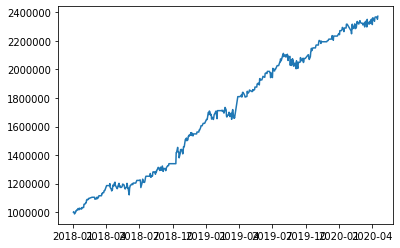

In [142]:
plt.plot(worth)

In [79]:
worth.to_excel('./4.4/金风科技worth滑动标准化.xlsx')

In [8]:
def back_test_all():
    companys = pd.read_excel('所有配对协整检验结果新增全样本残差单位根检验.xlsx',index_col=0)
    companys = companys.index
    result = pd.DataFrame(index=companys,columns=['夏普比率','最大回撤','胜率','收益率','年化收益率'])
    for company in companys:
        file_name = './data_without_formula/' + company + '.xlsx'
        #return:下单记录，净值，价差，夏普比率，最大回撤，胜率，收益率，年化收益率
        orders,worth,resid,sharp_ratio,max_dropdown,winning_prob,r,annualized_r = back_test(file_name)
        result.loc[company,'夏普比率'] = sharp_ratio
        result.loc[company,'最大回撤'] = max_dropdown
        result.loc[company,'胜率'] = winning_prob
        result.loc[company,'收益率'] = r
        result.loc[company,'年化收益率'] = annualized_r
    result.to_excel("./4.1/所有配对回测结果.xlsx")

In [7]:
def back_test_all_with_cost():
    companys = pd.read_excel('所有配对协整检验结果新增全样本残差单位根检验.xlsx',index_col=0)
    companys = companys.index
    result = pd.DataFrame(index=companys,columns=['夏普比率','最大回撤','胜率','收益率','年化收益率'])
    for company in companys:
        file_name = './data_without_formula/' + company + '.xlsx'
        #return:下单记录，净值，价差，夏普比率，最大回撤，胜率，收益率，年化收益率
        orders,worth,resid,sharp_ratio,max_dropdown,winning_prob,r,annualized_r = back_test(file_name,alpha1=1.5,alpha2=0,alpha3=9999)
        result.loc[company,'夏普比率'] = sharp_ratio
        result.loc[company,'最大回撤'] = max_dropdown
        result.loc[company,'胜率'] = winning_prob
        result.loc[company,'收益率'] = r
        result.loc[company,'年化收益率'] = annualized_r
    result.to_excel("./4.3/所有配对回测结果不使用止损.xlsx")

In [6]:
def optimistic():
    r_o = 0
    gama_o = 0
    alpha_o = 0
    for gama in range(51):
        for alpha in np.arange(0.4,3,0.1):
            try:
                orders,worth,resid,sharp_ratio,max_dropdown,winning_prob,r,annualized_r = back_test('./data_without_formula/金风科技.xlsx',gama=gama,alpha1=alpha,alpha2=0,alpha3=9999,cost=True)
            except:
                pass
            if r>=r_o:
                r_o = r
                gama_o = gama
                alpha_o = alpha
    return r_o,gama_o,alpha_o